In [6]:
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from tqdm.notebook import trange

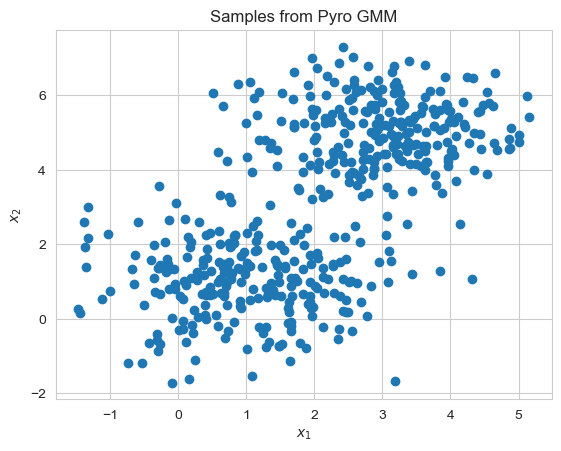

In [7]:
def gmm_2d(
    n_samples: int = 100,
    val_1: float = None,
    val_2: float = None,
    mix_vals: torch.Tensor = None,
):
    if mix_vals is None:
        mix_vals = torch.tensor([0.5, 0.5], dtype=torch.float32)

    with pyro.plate("n_samples", n_samples):
        which_dist = pyro.sample("which_dist", dist.Categorical(mix_vals))
        loc_1 = torch.tensor([1, 3], dtype=torch.float32)[which_dist]
        loc_2 = torch.tensor([1, 5], dtype=torch.float32)[which_dist]
        val_1 = pyro.sample(
            "val_1",
            dist.Normal(loc=loc_1, scale=1),
            obs=torch.full((n_samples,), val_1) if val_1 is not None else None,
            infer={"is_auxiliary": True}
            if val_1 is not None and mix_vals is not None
            else None,
        )
        val_2 = pyro.sample(
            "val_2",
            dist.Normal(loc=loc_2, scale=1),
            obs=torch.full((n_samples,), val_2) if val_2 is not None else None,
            infer={"is_auxiliary": True}
            if val_2 is not None and mix_vals is not None
            else None,
        )

    return torch.stack((val_1, val_2), dim=1)


samples = gmm_2d(500).T
plt.scatter(*samples)
plt.title("Samples from Pyro GMM")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

In [8]:
def gmm_2d_guide(n_samples: int = 100, val_1: float = None, val_2: float = None):
    mix_vals = pyro.param(
        "mix_vals",
        torch.tensor([0.5, 0.5], dtype=torch.float32),
        constraint=dist.constraints.simplex,
    )
    return gmm_2d(n_samples, val_1, val_2, mix_vals)

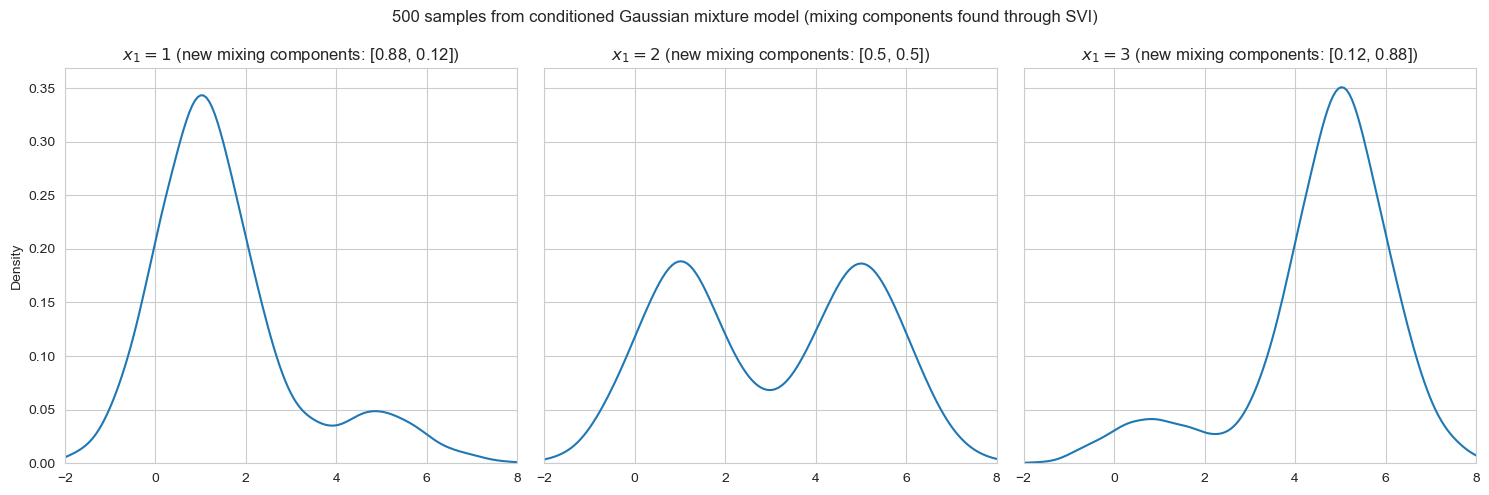

In [9]:
def plot_conditional(
    val_1: float, ax: plt.Axes = None, batch_size: int = 1_000, seed: int = 42
):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    adam = pyro.optim.Adam({"lr": 0.005})
    elbo = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(gmm_2d, gmm_2d_guide, adam, elbo)
    for _ in trange(1000, disable=ax is not None):
        svi.step(val_1=val_1, n_samples=batch_size)
    if ax is None:
        _, ax = plt.subplots()
    sns.kdeplot(gmm_2d_guide(val_1=val_1, n_samples=batch_size * 5)[:, 1], ax=ax)
    ax.set(
        xlim=(-2, 8),
        title=f"$x_1={val_1}$ "
        f"(new mixing components: "
        f"{[round(x, 2) for x in pyro.param('mix_vals').tolist()]})",
    )


_, axs = plt.subplots(ncols=3, sharey=True, tight_layout=True, figsize=(15, 5))
plot_conditional(1, ax=axs[0])
plot_conditional(2, ax=axs[1])
plot_conditional(3, ax=axs[2])
plt.suptitle(
    "500 samples from conditioned Gaussian mixture model"
    " (mixing components found through SVI)"
)
plt.show()